<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-04-20 20:20:29--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-04-20 20:20:30 (44.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

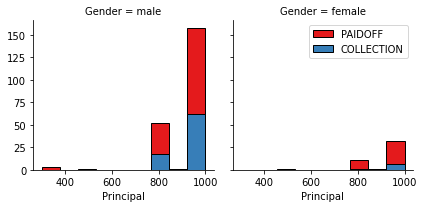

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

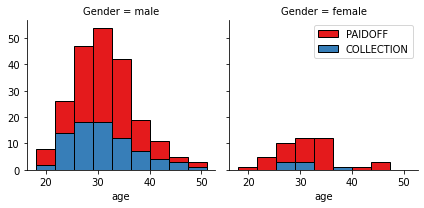

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


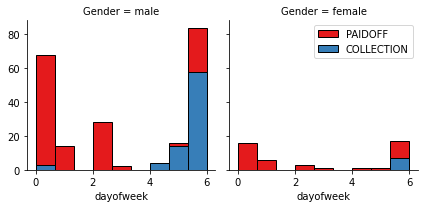

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loans

Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# My Take on Data Wrangling + Preprocessing for this dataset

In [20]:
InitialDF = pd.read_csv("loan_train.csv")

In [21]:
# Taking first look at data and verifying import success
InitialDF.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [22]:
InitialDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


In [23]:
# Dropping unnamed column 
InitialDF.drop('Unnamed: 0.1', axis = 1, inplace = True)

# Changing other "unnamed" into "ID"
InitialDF.rename(columns = {'Unnamed: 0':'ID'}, inplace=True)

In [24]:
# Checking adjustments
InitialDF.head()

,ID,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [25]:
# Converting Categorical Columns into numbers using 'Get Dummies'
EncodedDF = pd.get_dummies(data = InitialDF, columns = ['loan_status','education','Gender'], drop_first=True)

In [26]:
# Creating Full Encoded DF 
ProcessedDF = InitialDF.merge(EncodedDF)

In [27]:
# Checking Merge Success
ProcessedDF.head()

,ID,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,loan_status_PAIDOFF,education_High School or Below,education_Master or Above,education_college,Gender_male
0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male,1,1,0,0,1
1,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female,1,0,0,0,0
2,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male,1,0,0,1,1
3,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female,1,0,0,1,0
4,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male,1,0,0,1,1


In [28]:
# Dropping encoded columns
EncodedCols = ['loan_status','education','Gender']

ProcessedDF.drop(EncodedCols,axis=1,inplace=True)

In [29]:
# Converting date objects to datetime
ProcessedDF['due_date'] = pd.to_datetime(ProcessedDF['due_date'])
ProcessedDF['effective_date'] = pd.to_datetime(ProcessedDF['effective_date'])
ProcessedDF.head()

,ID,Principal,terms,effective_date,due_date,age,loan_status_PAIDOFF,education_High School or Below,education_Master or Above,education_college,Gender_male
0,0,1000,30,2016-09-08,2016-10-07,45,1,1,0,0,1
1,2,1000,30,2016-09-08,2016-10-07,33,1,0,0,0,0
2,3,1000,15,2016-09-08,2016-09-22,27,1,0,0,1,1
3,4,1000,30,2016-09-09,2016-10-08,28,1,0,0,1,0
4,6,1000,30,2016-09-09,2016-10-08,29,1,0,0,1,1


### Continued Preprocessing 

In [30]:
ProcessedDF['loan_status_PAIDOFF'].value_counts(normalize=True)

1    0.751445
0    0.248555
Name: loan_status_PAIDOFF, dtype: float64

Looks like about 25% of the the people in the training data defaulted on their loans! We'll have to see if that trend remains the same across the different groups.

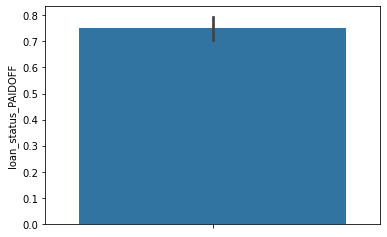

In [31]:
sns.barplot(data=ProcessedDF, y = 'loan_status_PAIDOFF')

In [32]:
# As we already saw in the above example, people who get the loan at the end of the week don't paid it off
ProcessedDF['dayofweek'] = ProcessedDF['effective_date'].dt.dayofweek
ProcessedDF['weekend'] = ProcessedDF['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [33]:
ProcessedDF.head()

,ID,Principal,terms,effective_date,due_date,age,loan_status_PAIDOFF,education_High School or Below,education_Master or Above,education_college,Gender_male,dayofweek,weekend
0,0,1000,30,2016-09-08,2016-10-07,45,1,1,0,0,1,3,0
1,2,1000,30,2016-09-08,2016-10-07,33,1,0,0,0,0,3,0
2,3,1000,15,2016-09-08,2016-09-22,27,1,0,0,1,1,3,0
3,4,1000,30,2016-09-09,2016-10-08,28,1,0,0,1,0,4,1
4,6,1000,30,2016-09-09,2016-10-08,29,1,0,0,1,1,4,1


In [34]:
# Creating duration category 
ProcessedDF['Loan_Duration'] = (ProcessedDF['due_date'] - ProcessedDF['effective_date']).dt.days
ProcessedDF['Loan_Duration'].head()

0    29
1    29
2    14
3    29
4    29
Name: Loan_Duration, dtype: int64

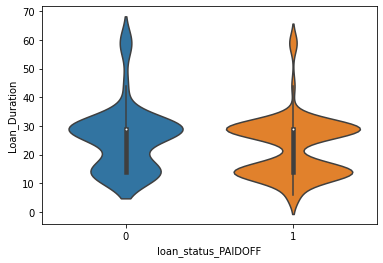

In [35]:
# Violin plot
sns.violinplot(data=ProcessedDF, y = 'Loan_Duration', x = 'loan_status_PAIDOFF')

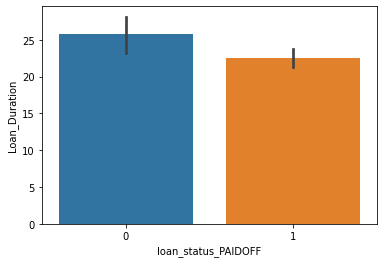

In [36]:
sns.barplot(data=ProcessedDF, y = 'Loan_Duration', x = 'loan_status_PAIDOFF')

Looks like longer loans have a higher chance of ending in Default 

Now that we've added what I thought the initial wrangling and preproccessing code was missing, lets create our feature dataset for use in our classification models

### Feature Construction

In [37]:
ProcessedDF.head()

,ID,Principal,terms,effective_date,due_date,age,loan_status_PAIDOFF,education_High School or Below,education_Master or Above,education_college,Gender_male,dayofweek,weekend,Loan_Duration
0,0,1000,30,2016-09-08,2016-10-07,45,1,1,0,0,1,3,0,29
1,2,1000,30,2016-09-08,2016-10-07,33,1,0,0,0,0,3,0,29
2,3,1000,15,2016-09-08,2016-09-22,27,1,0,0,1,1,3,0,14
3,4,1000,30,2016-09-09,2016-10-08,28,1,0,0,1,0,4,1,29
4,6,1000,30,2016-09-09,2016-10-08,29,1,0,0,1,1,4,1,29


In [38]:
Features = ProcessedDF[['Principal','terms','age','loan_status_PAIDOFF',
                            'education_High School or Below','education_Master or Above', 
                            'education_college','Gender_male','weekend','Loan_Duration']].copy()

In [39]:
Features.head()

,Principal,terms,age,loan_status_PAIDOFF,education_High School or Below,education_Master or Above,education_college,Gender_male,weekend,Loan_Duration
0,1000,30,45,1,1,0,0,1,0,29
1,1000,30,33,1,0,0,0,0,0,29
2,1000,15,27,1,0,0,1,1,0,14
3,1000,30,28,1,0,0,1,0,1,29
4,1000,30,29,1,0,0,1,1,1,29


In [40]:
X = Features.drop('loan_status_PAIDOFF', axis=1).copy()

In [41]:
Y = Features[['loan_status_PAIDOFF']].copy()

In [42]:
# Train/Test Split
from sklearn.model_selection import train_test_split as tts
X_Train, X_Test, Y_Train, Y_Test = tts(X,Y,test_size=.25,random_state=47)
print ('Train set:', X_Train.shape,  Y_Train.shape)
print ('Test set:', X_Test.shape,  Y_Test.shape)

Train set: (259, 9) (259, 1)
Test set: (87, 9) (87, 1)


In [43]:
# Data Normalization
X_Train = preprocessing.StandardScaler().fit(X_Train).transform(X_Train)

In [44]:
# Test Data Normalization
X_Test = preprocessing.StandardScaler().fit(X_Test).transform(X_Test)

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [45]:
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn import metrics

In [46]:
# Testing multiple Ks
Kmax = 15
mean_acc = np.zeros((Kmax-1))
std_acc = np.zeros((Kmax-1))

# Model training and prediction
for k in range(1,Kmax):
    # Building/Training
    Kmodel = KNNC(n_neighbors=k).fit(X_Train,np.ravel(Y_Train))
    #Predicting
    y_hat = Kmodel.predict(X_Test)
    # Accuracy Scores
    mean_acc[k-1]= metrics.accuracy_score(np.ravel(Y_Test),np.ravel(y_hat))
    std_acc[k-1]= np.std(np.ravel(y_hat)==np.ravel(Y_Test))/np.sqrt(np.ravel(y_hat).shape[0])

In [47]:
mean_acc

array([0.65517241, 0.64367816, 0.71264368, 0.67816092, 0.66666667,
       0.63218391, 0.68965517, 0.66666667, 0.71264368, 0.72413793,
       0.70114943, 0.71264368, 0.71264368, 0.71264368])

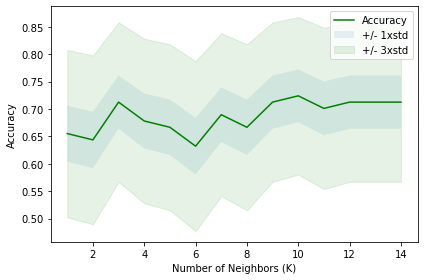

In [48]:
plt.plot(range(1,Kmax),mean_acc,'g')
plt.fill_between(range(1,Kmax),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Kmax),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [49]:
print("The greatest accuracy was {:.2%} with k =".format(mean_acc.max()), mean_acc.argmax()+1)

The greatest accuracy was 72.41% with k = 10


In [50]:
# Re-creating model with highest accuracy for final evaluation
KNNClassifier = KNNC(n_neighbors=10).fit(X_Train,np.ravel(Y_Train))

# Decision Tree


In [51]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [52]:
# Creating inital Tree 
LoanTree = DTC(criterion='entropy', class_weight='balanced')
LoanTree.fit(X_Train,Y_Train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

In [53]:
# Creating predictions from tree
PredTree = LoanTree.predict(X_Test)
# Checking Accuracy 
print("This decision tree's accuracy is {:.2%}".format(metrics.accuracy_score(Y_Test,PredTree)))

This decision tree's accuracy is 68.97%


# Support Vector Machine


In [54]:
from sklearn import svm 
svm_kernels = ['linear','poly','rbf','sigmoid']

In [55]:
# Creating 4 Support Vector Machines using the four different kernel options available 
for func in svm_kernels:
    SVM_model = svm.SVC(kernel=func,random_state=420)
    SVM_model.fit(X_Train,np.ravel(Y_Train))
    SVM_Pred = SVM_model.predict(X_Test)
    print("The Support Vector Machine, with the",func,"function, had an accuracy of {:.2%}".format(metrics.accuracy_score(Y_Test,SVM_Pred)))

The Support Vector Machine, with the linear function, had an accuracy of 75.86%
The Support Vector Machine, with the poly function, had an accuracy of 78.16%
The Support Vector Machine, with the rbf function, had an accuracy of 77.01%
The Support Vector Machine, with the sigmoid function, had an accuracy of 75.86%


In [56]:
# Creating a final SVM for evaluation using the highest accuracy function
SVM_model = svm.SVC(kernel='poly', random_state=420).fit(X_Train,np.ravel(Y_Train))

# Logistic Regression


In [57]:
from sklearn.linear_model import LogisticRegression as LR

In [58]:
# Creating and Training model using lbfgs solver in order to combat imbalance in data
LogRegModel = LR(C=.01,solver="lbfgs").fit(X_Train,np.ravel(Y_Train))
# Predicting on Test split
LR_Pred = LogRegModel.predict(X_Test)

In [59]:
print("The accuracy of the Logistic Regression Model is {:.2%}".format(metrics.accuracy_score(Y_Test,LR_Pred)))

The accuracy of the Logistic Regression Model is 75.86%


# Model Evaluation using Test set


In [60]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [61]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-20 20:20:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-20 20:20:34 (48.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [62]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Processing Test DataFrame for evaluation

In [63]:
# Dropping unnamed column 
test_df.drop('Unnamed: 0.1', axis = 1, inplace = True)

# Changing other "unnamed" into "ID"
test_df.rename(columns = {'Unnamed: 0':'ID'}, inplace=True)

In [64]:
# Converting Categorical Columns into numbers using 'Get Dummies'
EncodedDF_Test = pd.get_dummies(data = test_df, columns = ['loan_status','education','Gender'], drop_first=True)
# Creating Full Encoded DF 
test_df = test_df.merge(EncodedDF_Test)
# Dropping encoded columns
EncodedCols = ['loan_status','education','Gender']

test_df.drop(EncodedCols,axis=1,inplace=True)
# Converting date objects to datetime
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# Creating duration category 
test_df['Loan_Duration'] = (test_df['due_date'] - test_df['effective_date']).dt.days

In [65]:
test_df.head()

,ID,Principal,terms,effective_date,due_date,age,loan_status_PAIDOFF,education_High School or Below,education_Master or Above,education_college,Gender_male,dayofweek,weekend,Loan_Duration
0,1,1000,30,2016-09-08,2016-10-07,50,1,0,0,0,0,3,0,29
1,5,300,7,2016-09-09,2016-09-15,35,1,0,1,0,1,4,1,6
2,21,1000,30,2016-09-10,2016-10-09,43,1,1,0,0,0,5,1,29
3,24,1000,30,2016-09-10,2016-10-09,26,1,0,0,1,1,5,1,29
4,35,800,15,2016-09-11,2016-09-25,29,1,0,0,0,1,6,1,14


In [66]:
Features_test = test_df[['Principal','terms','age','loan_status_PAIDOFF',
                            'education_High School or Below','education_Master or Above', 
                            'education_college','Gender_male','weekend','Loan_Duration']].copy()
X = Features_test.drop('loan_status_PAIDOFF', axis=1).copy()
Y = Features_test[['loan_status_PAIDOFF']].copy()
# Data Normalization
X = preprocessing.StandardScaler().fit(X).transform(X)

## Testing Models against test data set

In [67]:
# KNN Classifier Predictions
KNN_Test_Preds = KNNClassifier.predict(X)
# Decision Tree Classifier Predictions
Test_PredTree = LoanTree.predict(X)
# SVM Classifier Predictions
SVM_Test_Preds = SVM_model.predict(X)
# Logistic Regression Model Predictions
LogReg_Test_Preds = LogRegModel.predict(X)

In [68]:
# Creating Report DataFrame
Report = pd.DataFrame()
Report['Classification Algorithms'] = ['KNN','Decision Tree','SVM','Logistic Regression']

In [69]:
# Adding Accuracy Scores
Report['Jaccard'] = [jaccard_score(Y,KNN_Test_Preds),jaccard_score(Y,Test_PredTree),
                     jaccard_score(Y,SVM_Test_Preds),jaccard_score(Y,LogReg_Test_Preds)]
Report['F1-score'] = [f1_score(Y,KNN_Test_Preds),f1_score(Y,Test_PredTree),
                      f1_score(Y,SVM_Test_Preds),f1_score(Y,LogReg_Test_Preds)]
Report['LogLoss'] = [log_loss(Y,KNN_Test_Preds),log_loss(Y,Test_PredTree),
                     log_loss(Y,SVM_Test_Preds),log_loss(Y,LogReg_Test_Preds)]

In [70]:
Report

,Classification Algorithms,Jaccard,F1-score,LogLoss
0,KNN,0.653061,0.790123,10.873452
1,Decision Tree,0.645833,0.784810,10.873437
2,SVM,0.722222,0.838710,9.594312
3,Logistic Regression,0.740741,0.851064,8.954705


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
